# Collaboration and Competition using ddpg and multi agent ddpg

---

In this notebook, I use the DDPG baseline and a variation of it to train multiples agents to play tennis in a Unity ML-Agents environment. This project correspond to the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

I wanted to increase progressivly the difficulty starting from the baseline DDPG method up to the MADDPG method. However, I am still having issue with the MADDPG version I implemented. Therefore, I will only present the DDPG variations I implemented for now.

I first implemented the baseline ddpg method where I use one agent to play with both racket. In orther word, the agent play with/against himself. Then, in the second part, I use two agents. Each of them use the baseline ddpg method. In this second part, agents can either share memory or not but they can not communicate (the actor and critic do not take into account other agent state and action). In the third part, I did the testing of each model.

# PART I: Introduction with random decision making
In this part, I introduce the environment and also the API use to play tennis. You can see two agents playing tennis at the end. Their decisions are made without any knowledge of how to play tennis (random value of actions).
Please, run I.1.a and I.1.b in this part before trying to run the other two part as I load libraries and define the environment in it.
 
##  I.1 Start the Environment and load libraries
First, I imports necessary packages. If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

### I.1.a Load libraries

In [1]:
from unityagents import UnityEnvironment
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from agent import Agent
from ihm_functions import plot_score, Load_environment,ddpg,multi_ddpg,ddpg_Test,double_ddpg_Test

### I.1.b Environment path

Before running the next cell, check that the path for the environment is correct. Change the `file_name` parameter to match the location of the Unity environment that you downloaded before.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

In [2]:
file_name="/home/raphe/Cours/Nanodegree_DRL/Tennis_Linux/Tennis.x86_64"

### I.1.c Charge environment

In [3]:
env = UnityEnvironment(file_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### I.1.d Define the brains
Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.
Here, we take the brain name and set it as default. Brains are responsible to manage the associated unity environment using agents action. We normaly use 2 agents. However, depending on the algorythm used to solve the environement it is possible to use only one.

In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## I.2 Examine the State and Action Spaces

As I stated in README.md, the goal of agents is to bounce a ball over a net using a racket as long as possible. If agents hit the ball over the net, they receive a reward of +0.1. But, if the ball hit the ground or is off limit (oustide of the table), the agent receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket.
Each agent has only two continuous actions available:
- Moving toward or away the net
- Jumping

In [5]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### Note
I definied in ihm_functions the "Load_environment" function. This function summarize the last cells (I.1.b to I.2). It takes as input file_name (path of the unity environment) and train_mode (training mode: True of False). It returns:
- env
- brain_name
- num_agents
- action_size
- state_size

I will use this function part II and III to load the environement.

## I.3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.09000000171363354
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.09000000171363354
Score (max over agents) from episode 5: 0.10000000149011612


## I.4 Close environment

In [7]:
env.close()

# Part II: Training
Before running this part, be sure to have run part I.1.a and b.
In part II, you can use the code to train your own agents.
There are 3 variations of DDPG:
- II.1 Naive approach: one agent playing with both racket. The agent is playing against himself.
- II.2 Multi agent DDPG with no shared memory and agents independant actor-critic networks. Each agent is trained for one side of the tennis court.
- II.3 Multi agent DDPG with shared memory and agents independant actor-critic networks. Each agent is trained for both side of the tennis court.

## II.1 DDPG: Naive approach

In the next code cells, you can found the body of the training code I implemented for one agent to learn how to play tennis. It uses the Python API to control the agent and receive feedback from the environment.
Here, I use the DDPG algorithm to control both racket.

### II.1.a Load environment and define agent

In [8]:
#Load environment
env,brain_name,num_agents,action_size,state_size = Load_environment(file_name,train_mode=True)

# Define agents
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### II.1.b Training

ddpg is definied in the ihm_function.py file. It takes as input:
- environment variables: env, env_info, state_size, action_size, brain_name,num_agents.
- agent
- rate is the ratio of decay applied to the noise added to each action. I add noise to action during training in order to enable the exploring of the environment.
- number of episode (n_episodes) and number of step (max_t).

It returns the scores.

The ddpg function uses the baseline ddpg algorytm with the API to train the agent. It sauvegards every 100 iterations the actor-critic network and also at convergence.

In [9]:
scores = ddpg(env, state_size, action_size, brain_name,num_agents, agent,rate=0.9999,n_episodes=5000, max_t=100000)

Episode 1486	Average Score: 0.5164000078104436	Score: 1.9000000283122063envionment solved after {}
 1486


### II.1.b Results
#### Score

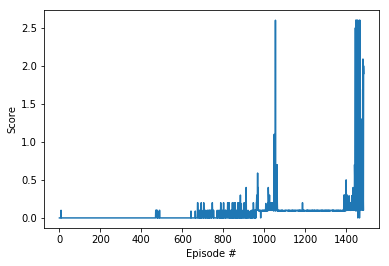

In [10]:
plot_score(scores)

### 1.c Close environment

In [11]:
env.close()

## II.2. Multi agents DDPG without sharing replay buffer
In the next code cells, you can found the body of the training code I implemented for multi agents with no shared replay buffer. Here, each agent get only informations about his own state and action. The agent is fully isolated. The actor-critic network as the replay buffer only use information related to the corresponding agent.
### II.2.a Load environment and define agents

In [12]:
# Load environment
env,brain_name,num_agents,action_size,state_size = Load_environment(file_name,train_mode=True)

# Define agents
agent = [ Agent(state_size=state_size, action_size=action_size, random_seed=10) for i in range(num_agents)]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### II.2.b Training
multi_ddpg is definied in ihm_function.py. It takes as input:
- environment variables: env, state_size, action_size, brain_name,num_agents.
- agents
- number of episode (n_episodes) and number of step (max_t).
- mode 
- weight_name correspond to a string using for saving the weight of the actor-critic network
- rate corresponds to the ratio at which the noise added to an action will decrease during one episode. (We add noise in order to explore the environment).

mode has two values: 
- mode = 0 for not sharing the replay buffer and (state,action,next_state,reward,done) 
- mode = 1 for sharing the replay buffer (state,action,next_state,reward,done)

multi_ddpg returns the scores obtained during training. It sauvegards every 100 iterations the actor-critic network and also at convergence.

In [13]:
scores = multi_ddpg(env, state_size, action_size,\
                    brain_name,num_agents,agent,\
                    n_episodes=5000, max_t=100000,\
                    weight_name="No_multi_checkpoint",rate=0.9999,mode=0)

Episode 3864	Average Score: 0.523700007814914	 max Score: 2.600000038743019envionment solved after {}
 3864


### II.2.c Results
#### Score

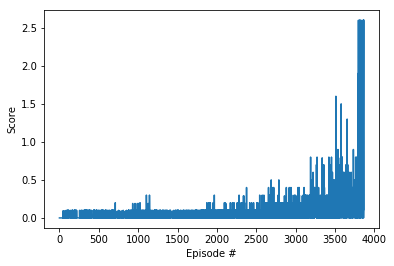

In [14]:
plot_score(scores)

###  II.2.d Close environment

In [15]:
env.close()

## II.3. Multi agents DDPG with shared memory replay
In the next code cells, you can found the body of the training code I implemented for multiple agents with shared memory. It uses the Python API to control the agent and receive feedback from the environment.
Here, each agent share a copy of the replay buffer. Both agent are trained to play at both side of the net. In otherword, the agent can swap position. However, agents do not take into account the comportement of other agents. The actor-critic network for each agent is trained using only a tuple respective to its own (state, action, next_state, next action).

### II.3.a Define agents

In [16]:
# Load environment
env,brain_name,num_agents,action_size,state_size = Load_environment(file_name,train_mode=True)

# Define agents
agent = [ Agent(state_size=state_size, action_size=action_size, random_seed=10) for i in range(num_agents)]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### II.3.b Training
I use the same function as in II.2 for training. Th changes are the name for the weight ("W_multi_checkpoint") and mode=1 for sharing (action,state, etc)

In [17]:
weight_name="'W_multi_checkpoint"
scores = multi_ddpg(env, state_size, action_size,\
                    brain_name,num_agents,agent,\
                    n_episodes=5000, max_t=100000,\
                    weight_name="checkpoint",rate=0.9999,mode=1)

Episode 2504	Average Score: 0.5034000075235963	 max Score: 2.600000038743019envionment solved after {}
 2504


### II.3.c Results
#### Score

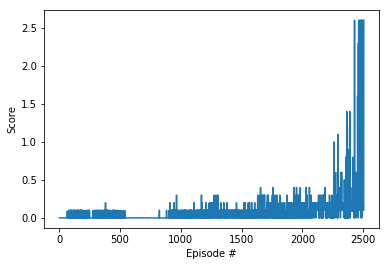

In [18]:
plot_score(scores)

###  II.3.d Close environment

In [19]:
env.close()

# Part III. Testing
Before running this part, be sure to have run part I.
In part III, you can load the pre-trained weight and check for each method the result.
There are 3 variations of DDPG:
- II.1 Naive approach: one agent playing with both racket. The agent is playing against himself.
- II.2 Multi agent DDPG with no shared memory and agents independant actor-critic networks. Each agent is trained for one side of the tennis court.
- II.3 Multi agent DDPG with shared memory and agents independant actor-critic networks. Each agent is trained for both side of the tennis court

## III.1 DDPG: test

### III.1.a Load environment and define agent

In [20]:
# Load environment
env,brain_name,num_agents,action_size,state_size = Load_environment(file_name,train_mode=False)

# Load agents
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### III.1.b Define the weights

In [21]:
file_name_actor='ddpg_checkpoint_actor.pth'
file_name_critic='ddpg_checkpoint_critic.pth'

### III.1.c Load the weight, start testing

ddpg_Test load the weight and use one agent to play tennis using the python API. It takes as inputs:
- Environment variables (env,brain_name,num_agents,agent)
- Name of the weight to load: file_name_actor,file_name_critic
- number of episode (n_episode) and number maximum of steps par episode (max_t)

In [22]:
scores=ddpg_Test(env,brain_name,num_agents,agent,file_name_actor,file_name_critic ,n_episodes=5,max_t=100000)

Episode 4	Average Score: 0.20000000298023224

### III.1.d Display score

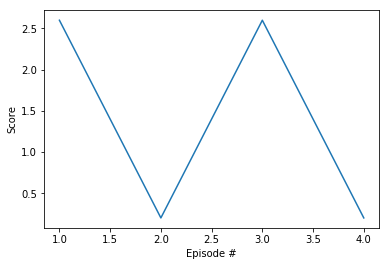

In [23]:
plot_score(scores)

### III.1.e Close environment

In [24]:
env.close()

## III.2 Multi agents DDPG (no shared memory): testing function

### III.2.a Load environment and define agents

In [25]:
# Load environment
env,brain_name,num_agents,action_size,state_size = Load_environment(file_name,train_mode=False)

# Define agents
agent = [ Agent(state_size=state_size, action_size=action_size, random_seed=10) for i in range(num_agents)]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### III.2.b Define the weights

In [26]:
file_name_actor=[]
file_name_critic=[]
for i in range(num_agents):
    file_name_actor.append('No_multi_checkpoint_actor'+str(i)+'.pth')
    file_name_critic.append('No_multi_checkpoint_critic'+str(i)+'.pth')

### III.2.c Load the weights, start testing
double_ddpg_Test load the weight and use two agents to play tennis using the python API. It takes as inputs:
- Environment variables (env,brain_name,num_agents,agent)
- Name of the weight to load: file_name_actor,file_name_critic
- number of episode (n_episode) and number maximum of steps par episode (max_t)

In [27]:
scores=double_ddpg_Test(env,brain_name,num_agents,agent,file_name_actor,file_name_critic ,n_episodes=5,max_t=100000)

Episode 4	Average Score: 0.50000000745058066

### III.2.d Display score

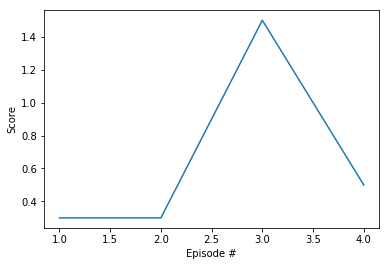

In [28]:
plot_score(scores)

### III.2.e Close environment

In [29]:
env.close()

## III.3 Multi agents DDPG (with shared memory): testing function
### III.3.a Load environment and define agents

In [37]:
# Load environment
env, brain_name, num_agents, action_size, state_size = Load_environment(file_name,train_mode=False)

# Define agents
agent = [Agent(state_size=state_size, action_size=action_size, random_seed=10) for i in range(num_agents)]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### III.3.b Define the weights

In [38]:
file_name_actor=[]
file_name_critic=[]
for i in range(num_agents):
    file_name_actor.append('W_multi_checkpoint_actor'+str(i)+'.pth')
    file_name_critic.append('W_multi_checkpoint_critic'+str(i)+'.pth')

### III.3.c Load the weights, start testing

In [39]:
scores=double_ddpg_Test(env,brain_name,num_agents,agent,file_name_actor,file_name_critic ,n_episodes=5,max_t=100000)

Episode 4	Average Score: 1.00000001490116126

### III.3.d Display score

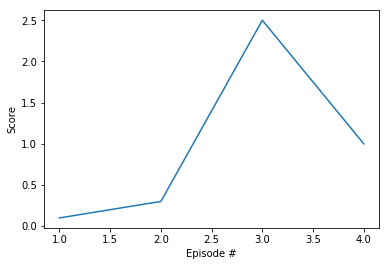

In [40]:
plot_score(scores)

### III.3.e End of testing

In [41]:
env.close()